In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve

import shap
from openai import OpenAI

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))
from config import OPENAICONFIGPARAMETERS as of

/opt/anaconda3/envs/python310_payment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
engine = 'gpt-4o-mini'
client = OpenAI(api_key=of.api_key, organization=of.organization_id, project=of.project_id)

In [4]:
df = pd.read_parquet("df.parquet")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,orig_balance_change,dest_balance_change,amount_to_orig_balance_ratio,is_zero_balance_after,high_value_transfer,dest_account_type,same_balance_before,same_balance_after
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,9839.64,0.0,0.057834,0,0,M,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1864.28,0.0,0.087731,0,0,M,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,181.00,0.0,0.994505,1,0,C,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,181.00,21182.0,0.994505,1,0,C,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,11668.14,0.0,0.280788,0,0,M,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 20 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   step                          int64  
 1   type                          object 
 2   amount                        float64
 3   nameOrig                      object 
 4   oldbalanceOrg                 float64
 5   newbalanceOrig                float64
 6   nameDest                      object 
 7   oldbalanceDest                float64
 8   newbalanceDest                float64
 9   isFraud                       int64  
 10  isFlaggedFraud                int64  
 11  hour                          int64  
 12  orig_balance_change           float64
 13  dest_balance_change           float64
 14  amount_to_orig_balance_ratio  float64
 15  is_zero_balance_after         int64  
 16  high_value_transfer           int64  
 17  dest_account_type             object 
 18  same_balance_before   

In [7]:
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour', 'orig_balance_change', 
                      'dest_balance_change', 'amount_to_orig_balance_ratio']
categorical_features = ['type', 'is_zero_balance_after', 'high_value_transfer', 'dest_account_type', 'same_balance_before', 'same_balance_after']

features = numerical_features + categorical_features

In [8]:
X = df[features]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [9]:
def train_predict_catboost(X_train, y_train, X_test, categorical_features):
    # Initialize the CatBoostClassifier
    catboost_model = CatBoostClassifier(random_seed=42, silent=True)
    
    # Train the model
    catboost_model.fit(X_train, y_train, cat_features=categorical_features)
    
    # Predict probabilities
    y_pred_proba = catboost_model.predict_proba(X_test)
    
    # Convert probabilities to predicted class
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    return y_pred, y_pred_proba, catboost_model

In [10]:
def compute_metrics(y_test, y_pred):
    # Accuracy
    acc_cat = accuracy_score(y_test, y_pred)
    print(f"Accuracy = {acc_cat}")
    
    # Balanced Accuracy
    bal_acc_cat = balanced_accuracy_score(y_test, y_pred)  
    print(f"Balanced Accuracy = {bal_acc_cat}")
    
    # F1 Score
    f1_cat = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score = {f1_cat}")
    
    # MCC (Matthews Correlation Coefficient)
    mcc_cat = matthews_corrcoef(y_test, y_pred)
    print(f"MCC = {mcc_cat}")

def plot_confusion_matrices(y_test, y_pred):
    # Confusion Matrices (raw counts) ensuring all classes are represented
    cm_cat = confusion_matrix(y_test, y_pred)

    # Normalize Confusion Matrices (row-wise)
    cm_cat_norm = cm_cat.astype('float') / cm_cat.sum(axis=1, keepdims=True)

    # Create side-by-side subplots for raw confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))   

    # CatBoost Confusion Matrix (Raw)
    sns.heatmap(cm_cat, annot=True, fmt="d", cmap="coolwarm", ax=ax1)
    ax1.set_title('Confusion Matrix for CatBoost (Raw)')
    ax1.set_ylabel('True Labels')
    ax1.set_xlabel('Predicted Labels')

    # CatBoost Confusion Matrix (Normalized)
    sns.heatmap(cm_cat_norm, annot=True, cmap="coolwarm", fmt='.4f', ax=ax2)
    ax2.set_title('Confusion Matrix for CatBoost (Normalized)')
    ax2.set_ylabel('True Labels')
    ax2.set_xlabel('Predicted Labels')
    
    
    plt.tight_layout()
    plt.show()

In [11]:
model_name = "catboost_model.pkl"
if os.path.isfile(model_name):
    # Load the CatBoost model
    with open(model_name, "rb") as file:
        catboost_model = pickle.load(file)
    # Predict probabilities
    y_pred_proba_cat = catboost_model.predict_proba(X_test)
    
    # Convert probabilities to predicted class
    y_pred_cat = np.argmax(y_pred_proba_cat, axis=1)
else:
    y_pred_cat, y_pred_proba_cat, catboost_model = train_predict_catboost(X_train, y_train, X_test, categorical_features)
    with open(model_name, "wb") as file:
        pickle.dump(catboost_model, file)

In [12]:
compute_metrics(y_test, y_pred_cat)

Accuracy = 0.9998031471312132
Balanced Accuracy = 0.9581252776339575
F1 Score = 0.9998023676905445
MCC = 0.9235353184492706


In [13]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083486
           1       0.93      0.92      0.92      6610

    accuracy                           1.00   5090096
   macro avg       0.97      0.96      0.96   5090096
weighted avg       1.00      1.00      1.00   5090096



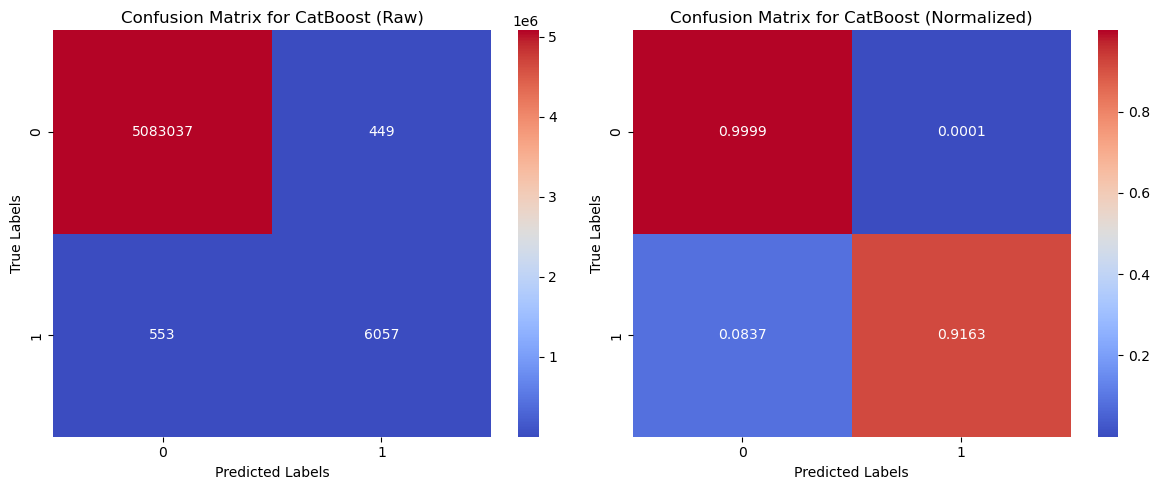

In [14]:
plot_confusion_matrices(y_test, y_pred_cat)

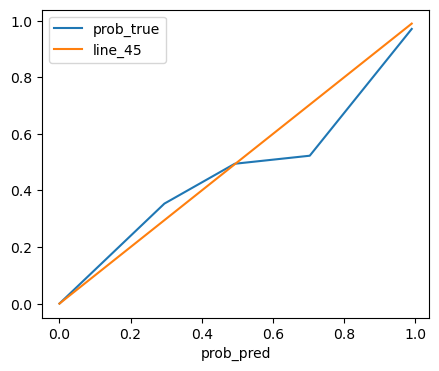

In [15]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_cat[:,1])
plt.rcParams["figure.figsize"] = (5,4)
cal_df = pd.DataFrame({"prob_true": prob_true, "prob_pred": prob_pred}).set_index("prob_pred")
cal_df["line_45"] = cal_df.index.values

cal_df.plot();

## Explain the results

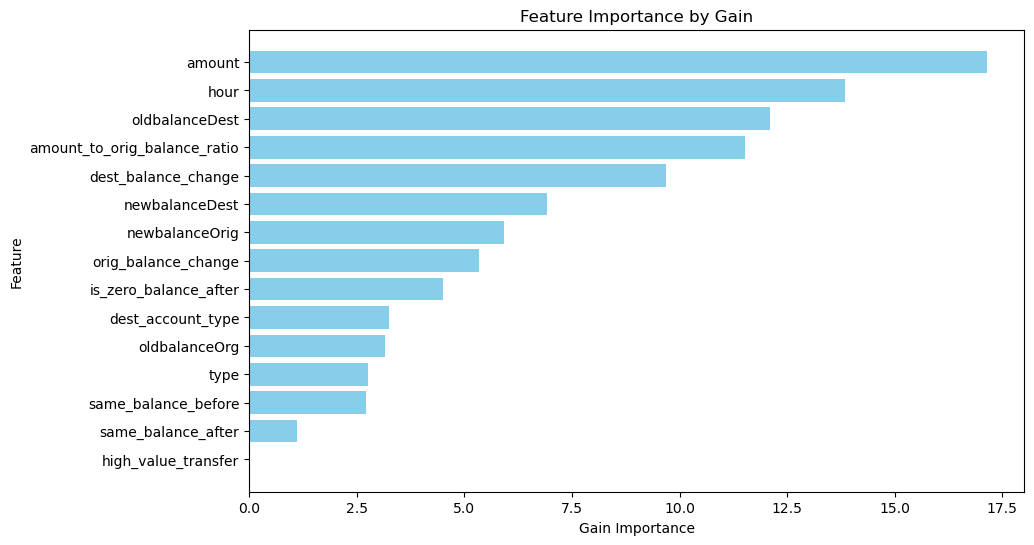

In [16]:
feature_importances = catboost_model.get_feature_importance(type="FeatureImportance")
# Plot the feature importances
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()

In [17]:
# Function to transform DataFrame to target format
def transform_dataframe(df):
    # Feature engineering
    # Create an `hour` column instead of `step` column because it might be useful to see how fraud payment occur at an hourly level in a day.
    df["hour"] = (df["step"] - 1) % 24

    # Balance Change: Calculate the change in the origin and destination balances
    df["orig_balance_change"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
    df["dest_balance_change"] = df["oldbalanceDest"] - df["newbalanceDest"]

    # Balance-to-Transaction Ratio: The ratio of the transaction amount to the origin account balance
    df["amount_to_orig_balance_ratio"] = df["amount"] / (df["oldbalanceOrg"] + 1)

    # Is Zero Balance After Transaction: Flag cases where the origin account's balance is zero immediately after the transaction
    df["is_zero_balance_after"] = (df["newbalanceOrig"] == 0).astype(int)

    # High-Value Transfer: Flag transactions that are above a certain threshold (e.g., 95th percentile) as potentially suspicious
    high_value_threshold = df["amount"].quantile(0.95)
    df["high_value_transfer"] = (df["amount"] > high_value_threshold).astype(int)

    # dest_account_type: the destination account starts with ‘M’, as merchants are less likely to engage in fraud
    df["dest_account_type"] = df["nameDest"].str[0]

    # Orig/Dest Same Balance: Check if the origin and destination balances are the same before or after the transaction, which may indicate balance masking
    df["same_balance_before"] = (df["oldbalanceOrg"] == df["oldbalanceDest"]).astype(int)
    df["same_balance_after"] = (df["newbalanceOrig"] == df["newbalanceDest"]).astype(int)

    numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour', 'orig_balance_change', 'dest_balance_change', 'amount_to_orig_balance_ratio']
    categorical_features = ['type', 'is_zero_balance_after', 'high_value_transfer', 'dest_account_type', 'same_balance_before', 'same_balance_after']
    
    features = numerical_features + categorical_features
    df_features = df[features].copy()
    
    return df_features

In [18]:
explainer = shap.TreeExplainer(catboost_model)

In [19]:
test_point_df_1 = pd.DataFrame([{
    "step": 62,
    "type": "TRANSFER",
    "amount": 401529.35,
    "nameOrig": "C330207825",
    "oldbalanceOrg": 401529.35,
    "newbalanceOrig": 0.0,
    "nameDest": "C1825454306",
    "oldbalanceDest": 0.0,
    "newbalanceDest": 0.0
}])

test_point_1 = transform_dataframe(test_point_df_1)
shap_values = explainer(test_point_1)
explanation = shap.Explanation(shap_values[0], data=test_point_1, feature_names=test_point_1.columns)
shap.initjs()  # Initialize JavaScript visualization for SHAP
shap.force_plot(explanation, link='logit')

In [20]:
test_point_df_1t = test_point_df_1.transpose().reset_index().rename(columns={'index':'Feature', 0:'Values'})

# SHAP values for each feature
shap_values_instance = shap_values.values[0]
feature_names = test_point_1.columns

# Create a DataFrame to display each feature's SHAP value and probability impact
df_shap_tp1 = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Value (Log-Odds)': shap_values_instance,
    'SHAP Value Absolute Value': np.abs(shap_values_instance),
})

df_shap_tp1 = df_shap_tp1.sort_values(by='SHAP Value Absolute Value', ascending=False).reset_index(drop=True)
df_shap_tp1 = df_shap_tp1.merge(test_point_df_1t, on='Feature')

In [21]:
df_shap_tp1

,Feature,SHAP Value (Log-Odds),SHAP Value Absolute Value,Values
0,amount_to_orig_balance_ratio,9.867294,9.867294,0.999998
1,orig_balance_change,5.712851,5.712851,401529.35
2,is_zero_balance_after,4.085993,4.085993,1
3,newbalanceOrig,1.914017,1.914017,0.0
4,oldbalanceDest,1.549784,1.549784,0.0
5,dest_account_type,1.530810,1.530810,C
6,dest_balance_change,1.474194,1.474194,0.0
7,type,0.959158,0.959158,TRANSFER
8,same_balance_after,0.895349,0.895349,1
9,amount,-0.759881,0.759881,401529.35


In [22]:
test_point_df_2 = pd.DataFrame([{
    "step": 278,
    "type": "CASH_IN",
    "amount": 330218.42,
    "nameOrig": "C632336343",
    "oldbalanceOrg": 20866.0,
    "newbalanceOrig": 351084.42,
    "nameDest": "C834976624",
    "oldbalanceDest": 452419.57,
    "newbalanceDest": 122201.15
}])

test_point_2 = transform_dataframe(test_point_df_2)
shap_values = explainer(test_point_2)
explanation = shap.Explanation(shap_values[0], data=test_point_2, feature_names=test_point_2.columns)
shap.initjs()  # Initialize JavaScript visualization for SHAP
shap.force_plot(explanation, link='logit')

In [23]:
test_point_df_2t = test_point_df_2.transpose().reset_index().rename(columns={'index':'Feature', 0:'Values'})

# SHAP values for each feature
shap_values_instance = shap_values.values[0]
feature_names = test_point_2.columns

# Create a DataFrame to display each feature's SHAP value and probability impact
df_shap_tp2 = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Value (Log-Odds)': shap_values_instance,
    'SHAP Value Absolute Value': np.abs(shap_values_instance),
})

df_shap_tp2 = df_shap_tp2.sort_values(by='SHAP Value Absolute Value', ascending=False).reset_index(drop=True)
df_shap_tp2 = df_shap_tp2.merge(test_point_df_2t, on='Feature')

In [24]:
df_shap_tp2

,Feature,SHAP Value (Log-Odds),SHAP Value Absolute Value,Values
0,dest_balance_change,-1.461496,1.461496,330218.42
1,oldbalanceDest,-1.095585,1.095585,452419.57
2,amount,0.735672,0.735672,330218.42
3,newbalanceDest,-0.406634,0.406634,122201.15
4,oldbalanceOrg,-0.306233,0.306233,20866.0
5,amount_to_orig_balance_ratio,0.275114,0.275114,15.824911
6,newbalanceOrig,0.177004,0.177004,351084.42
7,dest_account_type,-0.123780,0.123780,C
8,orig_balance_change,0.079756,0.079756,-330218.42
9,hour,-0.078906,0.078906,13


In [25]:
def get_llm_summary(client, df):
    top_contributors = df.head(5)
    
    # Generate the prompt
    prompt = f"""
    Please explain to the client the top 5 features contributing to the model's prediction, based on SHAP values. The SHAP values represent each feature's impact on the prediction, with higher absolute values indicating a stronger influence. Here is a breakdown of the top 5 contributors:
    
    1. **{top_contributors.iloc[0]['Feature']}**: 
       - SHAP Value: {top_contributors.iloc[0]['SHAP Value (Log-Odds)']}
       - Absolute Impact: {top_contributors.iloc[0]['SHAP Value Absolute Value']}
       - Feature Value: {top_contributors.iloc[0]['Values']}
    
    2. **{top_contributors.iloc[1]['Feature']}**: 
       - SHAP Value: {top_contributors.iloc[1]['SHAP Value (Log-Odds)']}
       - Absolute Impact: {top_contributors.iloc[1]['SHAP Value Absolute Value']}
       - Feature Value: {top_contributors.iloc[1]['Values']}
    
    3. **{top_contributors.iloc[2]['Feature']}**: 
       - SHAP Value: {top_contributors.iloc[2]['SHAP Value (Log-Odds)']}
       - Absolute Impact: {top_contributors.iloc[2]['SHAP Value Absolute Value']}
       - Feature Value: {top_contributors.iloc[2]['Values']}
    
    4. **{top_contributors.iloc[3]['Feature']}**: 
       - SHAP Value: {top_contributors.iloc[3]['SHAP Value (Log-Odds)']}
       - Absolute Impact: {top_contributors.iloc[3]['SHAP Value Absolute Value']}
       - Feature Value: {top_contributors.iloc[3]['Values']}
    
    5. **{top_contributors.iloc[4]['Feature']}**: 
       - SHAP Value: {top_contributors.iloc[4]['SHAP Value (Log-Odds)']}
       - Absolute Impact: {top_contributors.iloc[4]['SHAP Value Absolute Value']}
       - Feature Value: {top_contributors.iloc[4]['Values']}
    
    These features had the most significant influence on the prediction outcome, with positive or negative SHAP values indicating the direction of their effect.
    """
    completions = client.chat.completions.create(model=engine, 
                                                 temperature=0, 
                                                 messages=[{"role": "user", "content": prompt}])
    summary = completions.choices[0].message.content
    return summary

In [26]:
answer1 = get_llm_summary(client, df_shap_tp1)

In [27]:
print(answer1)

Certainly! Here’s a detailed explanation of the top 5 features contributing to the model's prediction, based on their SHAP values. SHAP (SHapley Additive exPlanations) values help us understand the impact of each feature on the model's predictions, with higher absolute values indicating a stronger influence.

1. **amount_to_orig_balance_ratio**:
   - **SHAP Value**: 9.8673
   - **Absolute Impact**: 9.8673
   - **Feature Value**: 0.9999975
   - **Explanation**: This feature represents the ratio of the transaction amount to the original balance. A value close to 1 indicates that the transaction amount is nearly equal to the original balance, which significantly influences the prediction. The high SHAP value suggests that this feature strongly contributes to the model's prediction, likely indicating a higher risk or likelihood of a certain outcome.

2. **orig_balance_change**:
   - **SHAP Value**: 5.7129
   - **Absolute Impact**: 5.7129
   - **Feature Value**: 401529.35
   - **Explanation

In [28]:
answer2 = get_llm_summary(client, df_shap_tp2)

In [29]:
print(answer2)

Certainly! Here’s a breakdown of the top 5 features contributing to the model's prediction, based on SHAP values. Each feature's SHAP value indicates its impact on the prediction, with higher absolute values signifying a stronger influence. 

1. **dest_balance_change**:
   - **SHAP Value**: -1.4615
   - **Absolute Impact**: 1.4615
   - **Feature Value**: 330218.42
   - **Explanation**: This feature represents the change in balance for the destination account. A negative SHAP value indicates that an increase in this balance change significantly decreases the likelihood of the predicted outcome. In this case, a large positive balance change is associated with a lower risk.

2. **oldbalanceDest**:
   - **SHAP Value**: -1.0956
   - **Absolute Impact**: 1.0956
   - **Feature Value**: 452419.57
   - **Explanation**: This feature reflects the previous balance of the destination account before the transaction. Similar to the first feature, a higher old balance in the destination account negati